In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

random.seed(1234)   
np.random.seed(1234)


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [11]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                save_to, epoch = 2,
                dense_layers_unit_array=[],
                patience=10, epoch_denominator=10.,
                isConstantLearningRate=False, learningRate=0.001,
                activation="relu", isBatchNormalized=False,dropOutRate=-1):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("epoch:",epoch)
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))        
        
    print("patience:",patience,"; epoch_denominator:",epoch_denominator)
    print("isConstantLearningRate:",isConstantLearningRate,"; learningRate:",learningRate) 
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, x_train.shape[1]))
        model.summary()
        tf.keras.utils.plot_model(model)

        opt_adam = keras.optimizers.Adam(learning_rate=learningRate)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
            
        if isConstantLearningRate:  
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
        else:  
            lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))
            
        model.compile(optimizer=opt_adam,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

        
    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))


In [4]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 1
dense_layer[0]; unit:512
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 1,916,420
Trainable params: 1,916,420
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0

Epoch 00025: early stopping


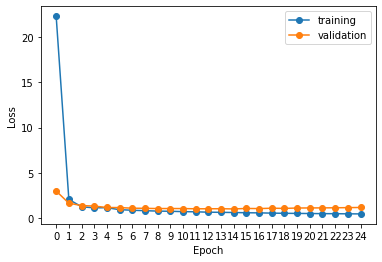

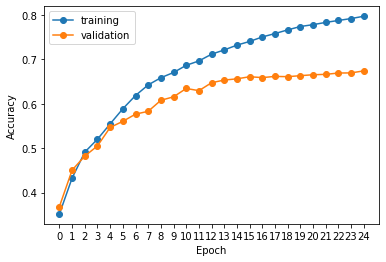

251/251 [==============================] - 2s 6ms/step - loss: 1.1588 - accuracy: 0.6875 - precision: 0.7608 - recall: 0.6241

Test Acc. 68.75%
              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1978
           1       0.74      0.68      0.71      1957
           2       0.86      0.69      0.77      2069
           3       0.55      0.74      0.63      2011

   micro avg       0.69      0.69      0.69      8015
   macro avg       0.71      0.69      0.69      8015
weighted avg       0.71      0.69      0.69      8015
 samples avg       0.69      0.69      0.69      8015



In [6]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512]
                    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               131328    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 2,046,724
Trainable params: 

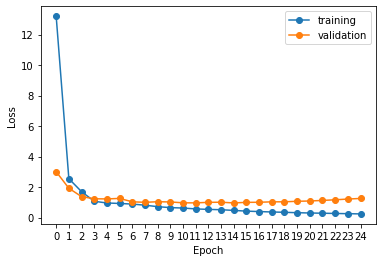

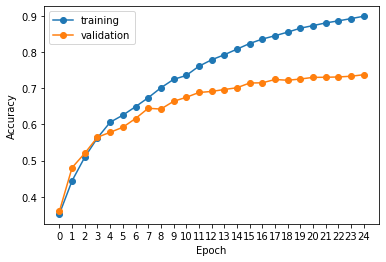

251/251 [==============================] - 2s 6ms/step - loss: 1.2255 - accuracy: 0.7493 - precision: 0.7839 - recall: 0.7125

Test Acc. 74.93%
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      1978
           1       0.76      0.77      0.76      1957
           2       0.81      0.80      0.81      2069
           3       0.73      0.69      0.71      2011

   micro avg       0.75      0.75      0.75      8015
   macro avg       0.75      0.75      0.75      8015
weighted avg       0.75      0.75      0.75      8015
 samples avg       0.75      0.75      0.75      8015



In [8]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256]
                    )


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:512
dense_layer[1]; unit:256
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 512)               1914368   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
fc_1 (Dense)                 (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
__________________

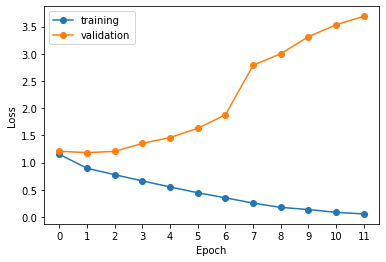

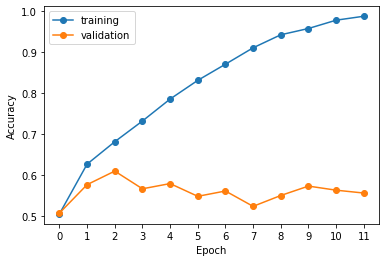

251/251 [==============================] - 2s 6ms/step - loss: 5.6787 - accuracy: 0.5604 - precision: 0.5824 - recall: 0.5298

Test Acc. 56.04%
              precision    recall  f1-score   support

           0       0.83      0.34      0.49      1978
           1       0.81      0.42      0.55      1957
           2       0.84      0.54      0.66      2069
           3       0.39      0.93      0.54      2011

   micro avg       0.56      0.56      0.56      8015
   macro avg       0.72      0.56      0.56      8015
weighted avg       0.72      0.56      0.56      8015
 samples avg       0.56      0.56      0.56      8015



In [13]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512,256],
                     isBatchNormalized=True
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:1024
dense_layer[1]; unit:512
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 1024)              3828736   
_________________________________________________________________
fc_1 (Dense)                 (None, 512)               524800    
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 4,

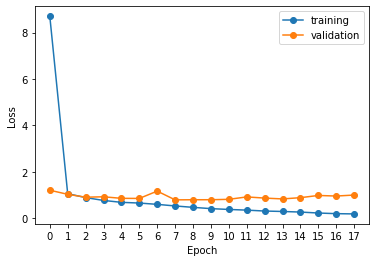

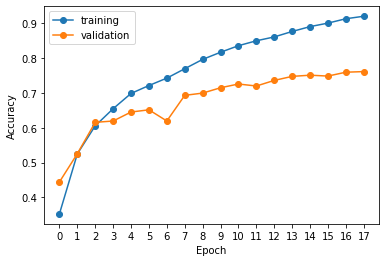

251/251 [==============================] - 2s 6ms/step - loss: 0.9227 - accuracy: 0.7722 - precision: 0.8042 - recall: 0.7466

Test Acc. 77.22%
              precision    recall  f1-score   support

           0       0.84      0.67      0.75      1978
           1       0.76      0.82      0.79      1957
           2       0.84      0.81      0.82      2069
           3       0.68      0.79      0.73      2011

   micro avg       0.77      0.77      0.77      8015
   macro avg       0.78      0.77      0.77      8015
weighted avg       0.78      0.77      0.77      8015
 samples avg       0.77      0.77      0.77      8015



In [6]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[1024,512]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:2048
dense_layer[1]; unit:1024
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 2048)              7657472   
_________________________________________________________________
fc_1 (Dense)                 (None, 1024)              2098176   
_________________________________________________________________
dense (Dense)                (None, 4)                 4100      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 9

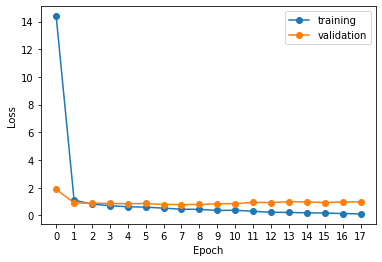

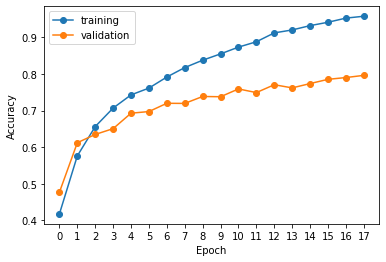

251/251 [==============================] - 2s 6ms/step - loss: 1.0454 - accuracy: 0.7915 - precision: 0.8081 - recall: 0.7792

Test Acc. 79.15%
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1978
           1       0.75      0.85      0.80      1957
           2       0.87      0.80      0.83      2069
           3       0.77      0.76      0.77      2011

   micro avg       0.79      0.79      0.79      8015
   macro avg       0.79      0.79      0.79      8015
weighted avg       0.79      0.79      0.79      8015
 samples avg       0.79      0.79      0.79      8015



In [7]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[2048,1024]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:2048
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
fc_1 (Dense)                 (None, 2048)              8390656   
_________________________________________________________________
dense (Dense)                (None, 4)                 8196      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 2

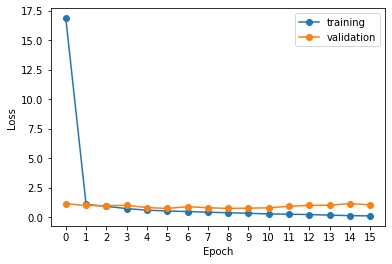

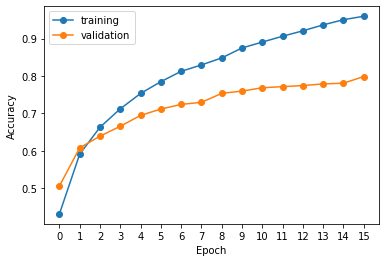

251/251 [==============================] - 2s 6ms/step - loss: 1.0362 - accuracy: 0.8040 - precision: 0.8147 - recall: 0.7964

Test Acc. 80.40%
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      1978
           1       0.80      0.80      0.80      1957
           2       0.84      0.86      0.85      2069
           3       0.76      0.80      0.78      2011

   micro avg       0.80      0.80      0.80      8015
   macro avg       0.80      0.80      0.80      8015
weighted avg       0.80      0.80      0.80      8015
 samples avg       0.80      0.80      0.80      8015



In [9]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 3
dense_layer[0]; unit:4096
dense_layer[1]; unit:2048
dense_layer[2]; unit:1024
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
fc_1 (Dense)                 (None, 2048)              8390656   
_________________________________________________________________
fc_2 (Dense)                 (None, 1024)              2098176   
_________________________________________________________________
dense (Dense)                (None, 4)                 

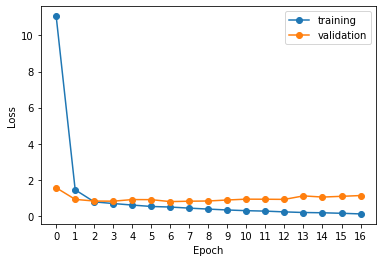

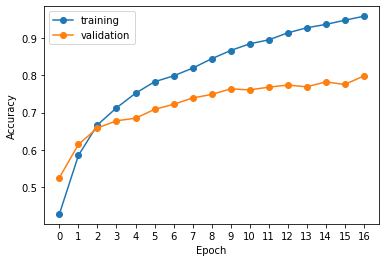

251/251 [==============================] - 2s 6ms/step - loss: 1.1643 - accuracy: 0.7999 - precision: 0.8125 - recall: 0.7879

Test Acc. 79.99%
              precision    recall  f1-score   support

           0       0.82      0.76      0.78      1978
           1       0.77      0.84      0.81      1957
           2       0.88      0.80      0.84      2069
           3       0.74      0.81      0.77      2011

   micro avg       0.80      0.80      0.80      8015
   macro avg       0.80      0.80      0.80      8015
weighted avg       0.80      0.80      0.80      8015
 samples avg       0.80      0.80      0.80      8015



In [10]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048,1024]
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:2048
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 2048)              8390656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0      

752/752 [==============================] - 10s 14ms/step - loss: 0.2114 - accuracy: 0.9167 - precision: 0.9503 - recall: 0.8900 - val_loss: 0.6716 - val_accuracy: 0.7941 - val_precision: 0.8317 - val_recall: 0.7642
Epoch 31/40
752/752 [==============================] - 11s 14ms/step - loss: 0.2208 - accuracy: 0.9121 - precision: 0.9443 - recall: 0.8872 - val_loss: 0.6654 - val_accuracy: 0.7964 - val_precision: 0.8365 - val_recall: 0.7618
Epoch 32/40
752/752 [==============================] - 11s 14ms/step - loss: 0.2036 - accuracy: 0.9206 - precision: 0.9507 - recall: 0.8951 - val_loss: 0.6715 - val_accuracy: 0.7972 - val_precision: 0.8376 - val_recall: 0.7654
Epoch 33/40
752/752 [==============================] - 11s 14ms/step - loss: 0.1908 - accuracy: 0.9267 - precision: 0.9531 - recall: 0.9041 - val_loss: 0.6863 - val_accuracy: 0.8011 - val_precision: 0.8352 - val_recall: 0.7695
Epoch 34/40
752/752 [==============================] - 11s 14ms/step - loss: 0.1897 - accuracy: 0.9276 -

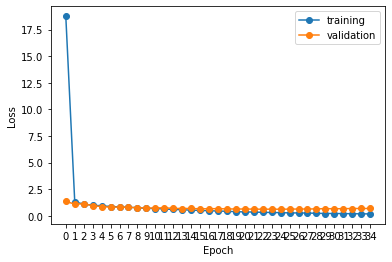

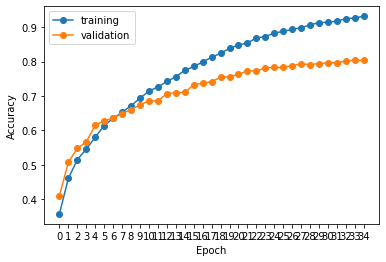

251/251 [==============================] - 2s 6ms/step - loss: 0.6564 - accuracy: 0.8072 - precision: 0.8399 - recall: 0.7792

Test Acc. 80.72%
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      1978
           1       0.83      0.80      0.81      1957
           2       0.84      0.85      0.85      2069
           3       0.77      0.78      0.77      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [12]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,2048], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:3072
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 3072)              12585984  
_________________________________________________________________
dropout_1 (Dropout)          (None, 3072)              0      

752/752 [==============================] - 11s 15ms/step - loss: 0.1991 - accuracy: 0.9253 - precision: 0.9511 - recall: 0.9021 - val_loss: 0.6559 - val_accuracy: 0.7986 - val_precision: 0.8354 - val_recall: 0.7655
Epoch 31/40
752/752 [==============================] - 11s 15ms/step - loss: 0.2114 - accuracy: 0.9241 - precision: 0.9493 - recall: 0.8999 - val_loss: 0.6542 - val_accuracy: 0.8018 - val_precision: 0.8364 - val_recall: 0.7712
Epoch 32/40
752/752 [==============================] - 11s 15ms/step - loss: 0.1879 - accuracy: 0.9296 - precision: 0.9518 - recall: 0.9091 - val_loss: 0.6629 - val_accuracy: 0.8038 - val_precision: 0.8407 - val_recall: 0.7743
Epoch 33/40
752/752 [==============================] - 11s 15ms/step - loss: 0.1753 - accuracy: 0.9363 - precision: 0.9587 - recall: 0.9172 - val_loss: 0.6569 - val_accuracy: 0.8085 - val_precision: 0.8392 - val_recall: 0.7803
Epoch 00033: early stopping


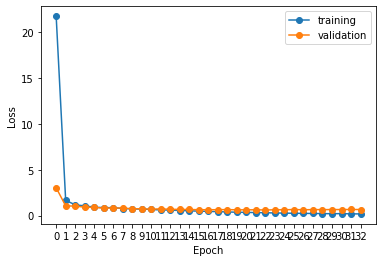

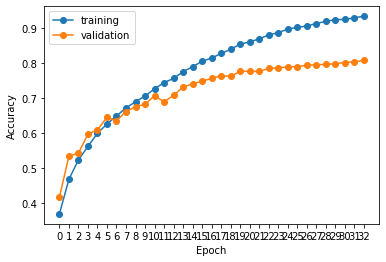

251/251 [==============================] - 2s 6ms/step - loss: 0.6616 - accuracy: 0.8107 - precision: 0.8425 - recall: 0.7844

Test Acc. 81.07%
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1978
           1       0.83      0.80      0.81      1957
           2       0.87      0.85      0.86      2069
           3       0.76      0.79      0.77      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [13]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,3072], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:4096
dense_layer[1]; unit:4096
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 4096)              15314944  
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 4096)              16781312  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0      

752/752 [==============================] - 12s 16ms/step - loss: 0.2807 - accuracy: 0.8938 - precision: 0.9254 - recall: 0.8630 - val_loss: 0.6785 - val_accuracy: 0.7895 - val_precision: 0.8274 - val_recall: 0.7519
Epoch 31/40
752/752 [==============================] - 12s 16ms/step - loss: 0.2638 - accuracy: 0.8992 - precision: 0.9299 - recall: 0.8717 - val_loss: 0.6757 - val_accuracy: 0.7904 - val_precision: 0.8282 - val_recall: 0.7547
Epoch 32/40
752/752 [==============================] - 12s 16ms/step - loss: 0.2488 - accuracy: 0.9078 - precision: 0.9363 - recall: 0.8820 - val_loss: 0.6844 - val_accuracy: 0.7960 - val_precision: 0.8318 - val_recall: 0.7642
Epoch 00032: early stopping


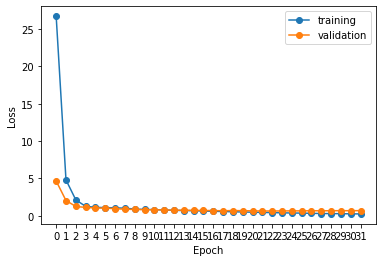

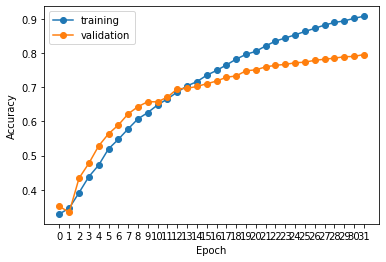

251/251 [==============================] - 2s 6ms/step - loss: 0.7085 - accuracy: 0.7949 - precision: 0.8278 - recall: 0.7609

Test Acc. 79.49%
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1978
           1       0.79      0.80      0.80      1957
           2       0.87      0.83      0.85      2069
           3       0.75      0.79      0.77      2011

   micro avg       0.79      0.79      0.79      8015
   macro avg       0.80      0.79      0.79      8015
weighted avg       0.80      0.79      0.80      8015
 samples avg       0.79      0.79      0.79      8015



In [14]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[4096,4096], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:5120
dense_layer[1]; unit:4096
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 5120)              19143680  
_________________________________________________________________
dropout (Dropout)            (None, 5120)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 4096)              20975616  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0      

752/752 [==============================] - 14s 18ms/step - loss: 0.2461 - accuracy: 0.9108 - precision: 0.9405 - recall: 0.8851 - val_loss: 0.6407 - val_accuracy: 0.8041 - val_precision: 0.8474 - val_recall: 0.7638
Epoch 31/40
752/752 [==============================] - 13s 18ms/step - loss: 0.2266 - accuracy: 0.9111 - precision: 0.9410 - recall: 0.8889 - val_loss: 0.6484 - val_accuracy: 0.8067 - val_precision: 0.8451 - val_recall: 0.7702
Epoch 32/40
752/752 [==============================] - 13s 18ms/step - loss: 0.2219 - accuracy: 0.9192 - precision: 0.9461 - recall: 0.8990 - val_loss: 0.6274 - val_accuracy: 0.8075 - val_precision: 0.8463 - val_recall: 0.7677
Epoch 33/40
752/752 [==============================] - 13s 18ms/step - loss: 0.2113 - accuracy: 0.9229 - precision: 0.9466 - recall: 0.8990 - val_loss: 0.6449 - val_accuracy: 0.8081 - val_precision: 0.8436 - val_recall: 0.7748
Epoch 34/40
752/752 [==============================] - 13s 18ms/step - loss: 0.1928 - accuracy: 0.9282 -

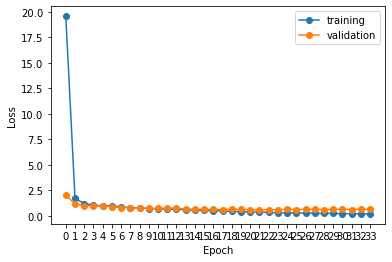

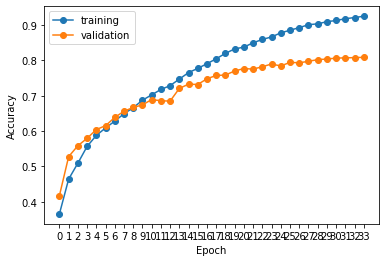

251/251 [==============================] - 2s 6ms/step - loss: 0.6373 - accuracy: 0.8125 - precision: 0.8476 - recall: 0.7798

Test Acc. 81.25%
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1978
           1       0.80      0.83      0.81      1957
           2       0.88      0.84      0.86      2069
           3       0.78      0.80      0.79      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.81      0.81      0.81      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [15]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[5120,4096], dropOutRate=0.2
                    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
epoch: 40
num_of_dense_layers: 2
dense_layer[0]; unit:6144
dense_layer[1]; unit:5120
patience: 10 ; epoch_denominator: 10.0
isConstantLearningRate: False ; learningRate: 0.001
isBatchNormalized: False ; dropOutRate: 0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_0 (Dense)                 (None, 6144)              22972416  
_________________________________________________________________
dropout (Dropout)            (None, 6144)              0         
_________________________________________________________________
fc_1 (Dense)                 (None, 5120)              31462400  
_________________________________________________________________
dropout_1 (Dropout)          (None, 5120)              0      

752/752 [==============================] - 16s 21ms/step - loss: 0.2271 - accuracy: 0.9162 - precision: 0.9404 - recall: 0.8947 - val_loss: 0.6863 - val_accuracy: 0.7999 - val_precision: 0.8350 - val_recall: 0.7670
Epoch 00030: early stopping


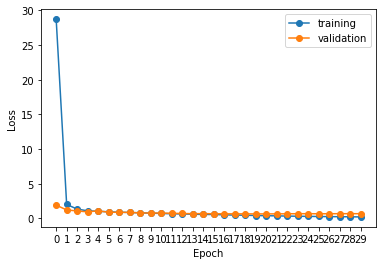

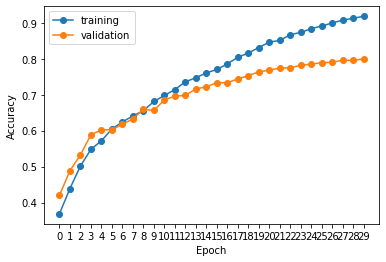

251/251 [==============================] - 2s 6ms/step - loss: 0.7056 - accuracy: 0.8054 - precision: 0.8379 - recall: 0.7750

Test Acc. 80.54%
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1978
           1       0.81      0.83      0.82      1957
           2       0.85      0.84      0.85      2069
           3       0.78      0.77      0.77      2011

   micro avg       0.81      0.81      0.81      8015
   macro avg       0.80      0.81      0.80      8015
weighted avg       0.81      0.81      0.81      8015
 samples avg       0.81      0.81      0.81      8015



In [16]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[6144,5120], dropOutRate=0.2
                    )